# Klasifikasi Citra Kanker Kulit dengan Deep Learning

Metode Sebelum data di load:
-  Dataset berasal dari dari kaggle (Skin Cancer MNIST: HAM10000).
-  Dataset dikelompokkan di folder yang berbeda sesuai kelasnya.
-  Dataset ditransformasi sehingga ukurannya 224x224.

### Data Preparation

In [ ]:
!gdown 1a7PgkbEklE9SGOdKj4gYJrT4PdU1YkMt

Downloading...
From: https://drive.google.com/uc?id=1a7PgkbEklE9SGOdKj4gYJrT4PdU1YkMt
To: /content/oversampled_dataset.zip
100% 260M/260M [00:02<00:00, 129MB/s]


In [ ]:
!unzip oversampled_dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (11).jpg  
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (12) - Copy.jpg  
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (13) - Copy.jpg  
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (14) - Copy.jpg  
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (15) - Copy.jpg  
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (16) - Copy.jpg  
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (17) - Copy.jpg  
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (18) - Copy.jpg  
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (19) - Copy.jpg  
  inflating: splitted_dataset/train_oversampled/vasc/ISIC_0028885 - Copy (2) - Copy.jpg  
  inflating: splitted_dataset/train_ove

In [ ]:
!pip install split-folders

In [ ]:
# !rm -r dataset

In [ ]:
import splitfolders
input_folder = "dataset"
output = "splitted_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2))

Copying files: 10015 files [00:01, 8230.87 files/s]


Rename foder val menjadi test.

In [ ]:
!mv splitted_dataset/train_oversampled splitted_dataset/train
!mv splitted_dataset/val splitted_dataset/test

mv: cannot stat 'splitted_dataset/train_oversampled': No such file or directory


### Import Library

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('default')

from scipy import ndimage

from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from sklearn.metrics import confusion_matrix

from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam

### Data Understanding

Visualisasi data untuk tiap kelas.

In [ ]:
fig = plt.figure(figsize=(10, 6))

# setting values to rows and column variables
rows = 2
columns = 4

# reading images
Image1 = imread('dataset/akiec/ISIC_0024329.jpg')
Image2 = imread('dataset/bcc/ISIC_0024331.jpg')
Image3 = imread('dataset/bkl/ISIC_0024312.jpg')
Image4 = imread('dataset/df/ISIC_0024318.jpg')
Image5 = imread('dataset/mel/ISIC_0024310.jpg')
Image6 = imread('dataset/nv/ISIC_0024306.jpg')
Image7 = imread('dataset/vasc/ISIC_0024370.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("akiec")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("bcc")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("bkl")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("df")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
# showing image
plt.imshow(Image5)
plt.axis('off')
plt.title("mel")

# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
# showing image
plt.imshow(Image6)
plt.axis('off')
plt.title("nv")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
# showing image
plt.imshow(Image7)
plt.axis('off')
plt.title("vasc")

FileNotFoundError: ignored

<Figure size 1000x600 with 0 Axes>

### Data Preparation

In [ ]:
!rm -r splitted_dataset/test/.ipynb_checkpoints
!rm -r splitted_dataset/train/.ipynb_checkpoints

rm: cannot remove 'splitted_dataset/test/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'splitted_dataset/train/.ipynb_checkpoints': No such file or directory


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 10
base_dir = os.path.join('splitted_dataset/train')

#Train-val set
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

#Test set
X_test = []
y_test = []
labels = ['akiec','bcc','bkl','df','mel','nv','vasc']

for i,label in enumerate(labels):
    folder = os.path.join("splitted_dataset/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing set
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 35903 images belonging to 7 classes.
Found 6335 images belonging to 7 classes.
Bentuk array dari dataset train (pelatihan) adalah: (10, 224, 224, 3) (10, 7)
Bentuk array dari dataset validation (validasi) adalah: (10, 224, 224, 3) (10, 7)
Bentuk array dari dataset test (pengujian) adalah: (1005, 224, 224, 3) (1005,)


Menyimpan label

In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


### Modelling

Menerapkan transfer learning dengan base model MobileNet.

In [ ]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False

Menambahkan layer kustom.

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 7175      
                                                                 
Total params: 3,236,039
Trainable params: 7,175
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# model = Sequential()
# model.add(Conv2D(16, kernel_size = (3,3), input_shape = (224, 224, 3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
# model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.summary()

In [ ]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['acc'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if logs.get('val_loss')<0.001:
          self.model.stop_training = True
callback2 = myCallback()

Proses training untuk layer kustom.

In [ ]:
# class_weights = {0: 9.,
#                 1: 2.,
#                 2: 3.,
#                 3: 10.,
#                 4: 5.,
#                 5: 1.,
#                 6: 10.}
from collections import Counter
counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    # class_weight=class_weights,
                    callbacks=[learning_rate_reduction, callback, callback2],
                    validation_data=val_generator)

Epoch 1/20
3591/3591 [==============================] - ETA: 0s - loss: 0.8237 - acc: 0.7069
Epoch 1: saving model to best_model.h5
3591/3591 [==============================] - 100s 25ms/step - loss: 0.8237 - acc: 0.7069 - val_loss: 0.9800 - val_acc: 0.6426 - lr: 0.0010
Epoch 2/20
3590/3591 [============================>.] - ETA: 0s - loss: 0.5419 - acc: 0.8107
Epoch 2: saving model to best_model.h5
3591/3591 [==============================] - 87s 24ms/step - loss: 0.5420 - acc: 0.8107 - val_loss: 1.0266 - val_acc: 0.6450 - lr: 0.0010
Epoch 3/20
3590/3591 [============================>.] - ETA: 0s - loss: 0.4657 - acc: 0.8392
Epoch 3: saving model to best_model.h5
3591/3591 [==============================] - 83s 23ms/step - loss: 0.4657 - acc: 0.8393 - val_loss: 1.0476 - val_acc: 0.6425 - lr: 0.0010
Epoch 4/20
3589/3591 [============================>.] - ETA: 0s - loss: 0.4291 - acc: 0.8466
Epoch 4: saving model to best_model.h5
3591/3591 [==============================] - 81s 22ms/ste

Visualisasi hasil training.

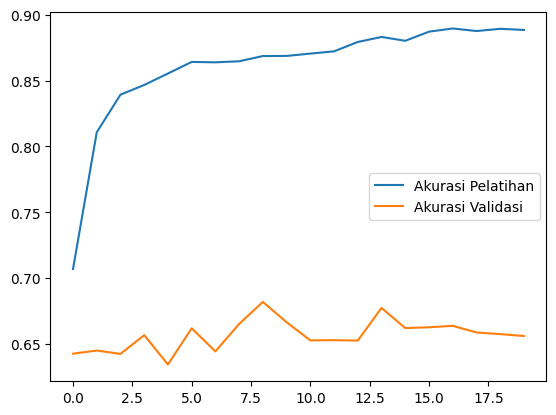

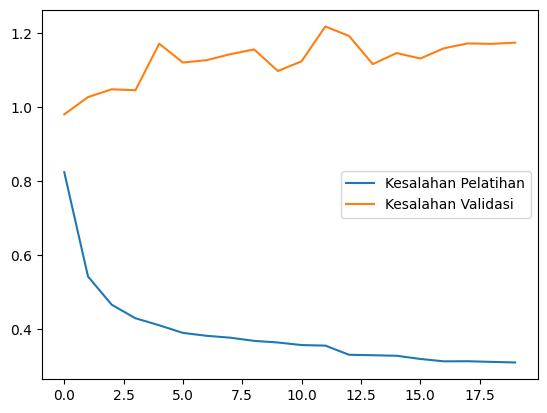

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Akurasi Validasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Kesalahan Validasi")
plt.legend()
plt.show()

Menyimpan model

In [ ]:
import keras

model = keras.models.load_model('best_model.h5')

### Evaluasi

In [ ]:
from keras.utils.np_utils import to_categorical
y_test2=to_categorical(y_test)
X_test3,y_test3=(X_test,y_test2)

In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
3591/3591 [==============================] - 70s 19ms/step - loss: 0.2187 - acc: 0.9374
[0.2186519354581833, 0.9373589754104614]
634/634 [==============================] - 12s 19ms/step - loss: 1.1735 - acc: 0.6560
[1.1735048294067383, 0.6560378670692444]
32/32 [==============================] - 2s 46ms/step - loss: 1.0655 - acc: 0.6806
[1.0654854774475098, 0.6805970072746277]


In [ ]:
y_true=np.argmax(y_test2,axis=1)
Y_pred=model.predict(X_test)
y_pred=np.argmax(Y_pred,axis=1)

32/32 [==============================] - 2s 34ms/step


Confusion matrix

Normalized confusion matrix
[[0.52 0.18 0.09 0.   0.15 0.06 0.  ]
 [0.04 0.6  0.17 0.   0.1  0.08 0.02]
 [0.13 0.03 0.59 0.   0.16 0.09 0.  ]
 [0.08 0.   0.33 0.5  0.   0.08 0.  ]
 [0.06 0.05 0.16 0.02 0.52 0.18 0.01]
 [0.01 0.01 0.11 0.   0.11 0.74 0.01]
 [0.   0.07 0.07 0.   0.07 0.   0.8 ]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Label Prediksi', ylabel='Label Benar'>

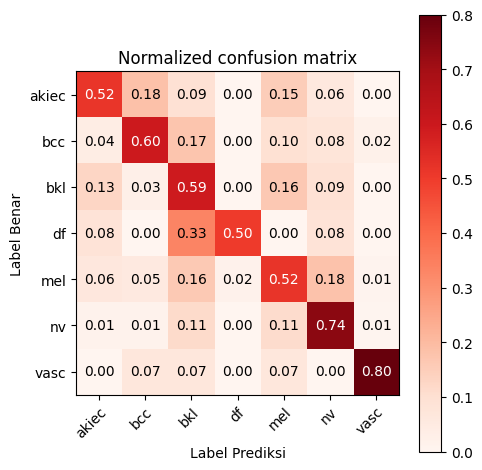

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.52      0.41        33
           1       0.54      0.60      0.57        52
           2       0.37      0.59      0.45       110
           3       0.60      0.50      0.55        12
           4       0.36      0.52      0.42       112
           5       0.93      0.74      0.82       671
           6       0.67      0.80      0.73        15

    accuracy                           0.68      1005
   macro avg       0.54      0.61      0.56      1005
weighted avg       0.76      0.68      0.71      1005



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
print('Precision: %.3f' % precision_score(y_true, y_pred,average='weighted'))
print('Recall: %.3f' % recall_score(y_true, y_pred,average='weighted'))
print('F1 Score: %.3f' % f1_score(y_true, y_pred,average="weighted"))

Accuracy: 0.681
Precision: 0.758
Recall: 0.681
F1 Score: 0.707


### Demo Prediksi Citra

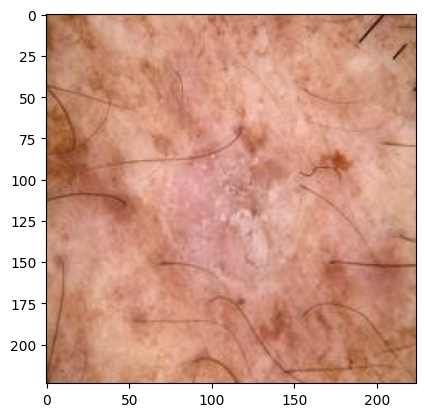

Label yang benar adalah: 0 : akiec
1/1 [==============================] - 0s 34ms/step
Nilai yang diprediksi adalah: [8.75e-01 1.18e-01 6.69e-03 2.59e-12 2.57e-05 1.40e-04 1.27e-10]
Label yang diprediksi adalah: 0 : akiec
Prediksi benar


In [ ]:
n = 10 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")